Spatial Data and New York City Schools
======================================
This notebook explores some of the basic
spatial data available for New York City Public schools
from the [NYC Open Data Portal](https://opendata.cityofnewyork.us/)
and [`nycschools` package](https://adelphi-ed-tech.github.io/nycschools/intro.html).

Import Libraries & Load Data
-----------------------------
In this cell we import the `matplotlib` and `seaborn` python libraries
that will help us generate static maps and plots, and we also load
the `schools` and `geo` packages from `nycsschools`.

Once the libraries are loaded, we the data for district shape,s school demographics, and school locations.

In [5]:
# make a district map with matplotlib
from nycschools import schools, geo, ui
import matplotlib.pyplot as plt
import seaborn as sns
import math

# get the data we need using nycschools
districts = geo.load_districts()
demos = schools.load_school_demographics()
locations = geo.load_school_locations()

Looking at changing demographics
--------------------------------
Below, we will group the school demographics at the school
district level and then make a choropleth map where the color
indicates the percentage of students who are learning English
as a new language.

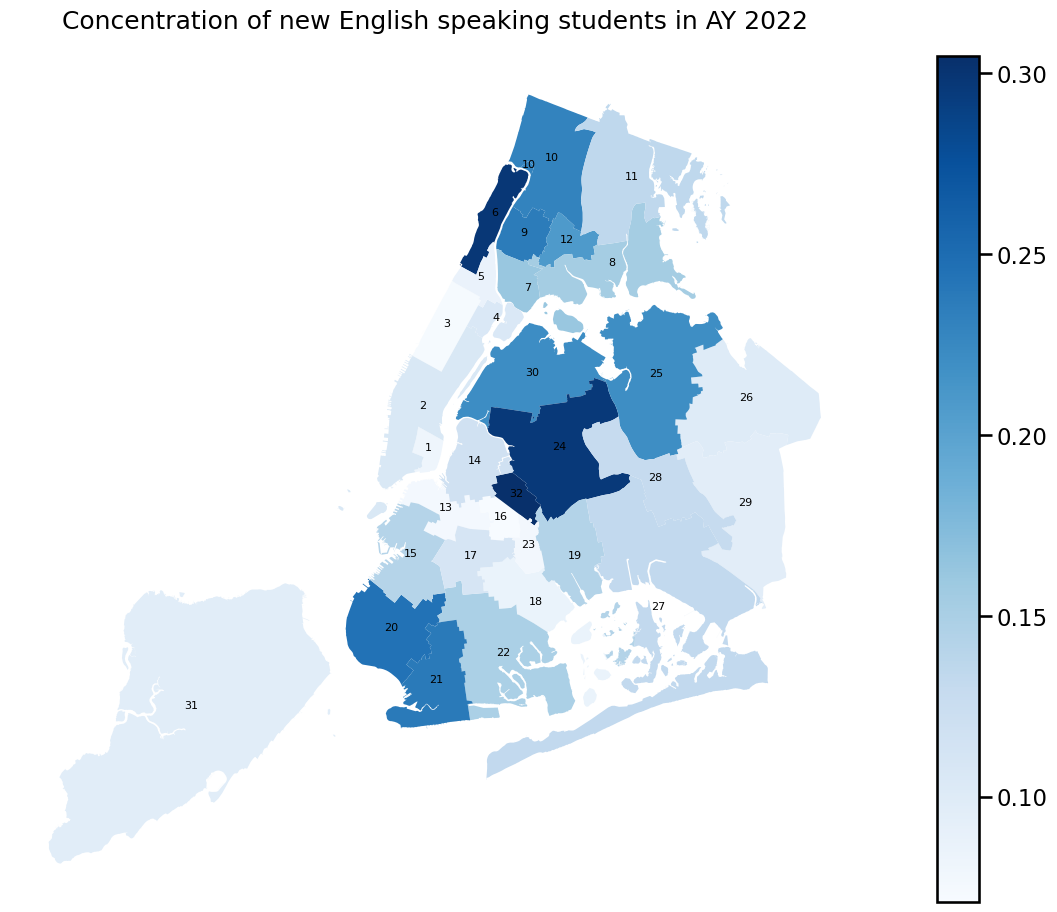

In [6]:
# get the district average for ENL students in the most recent academic year
latest_ay = demos.ay.max()
key_col = "ell_pct"
ell = demos[demos.ay == latest_ay].groupby("district").agg({key_col: "mean"}).reset_index()

# merge the district data with our disrict shapes
ell_map_data = districts.merge(ell, on="district", how="inner")

# configure the look of our map
fig, ax = plt.subplots(figsize=(16, 9))
sns.set_context('talk')

# don't show the chart boundary box or x/y ticks
plt.axis('off')
fig.tight_layout()
ax.set_title(f'Concentration of new English speaking students in AY {latest_ay}', pad=20)

# write the district numbers on the map at the center of the district shape
ui.label_plot(ax, ell_map_data, "district")

# plot districts, hide the axis labels, use the title "District % Poverty"
_ = ell_map_data.plot(ax=ax, column=key_col, cmap="Blues", legend=True)

Changes over time
-----------------
Now that we have our basic example, we can wrap this code up in a function
and then loop over each year in our data set to create a series
that will let us see changes over time.


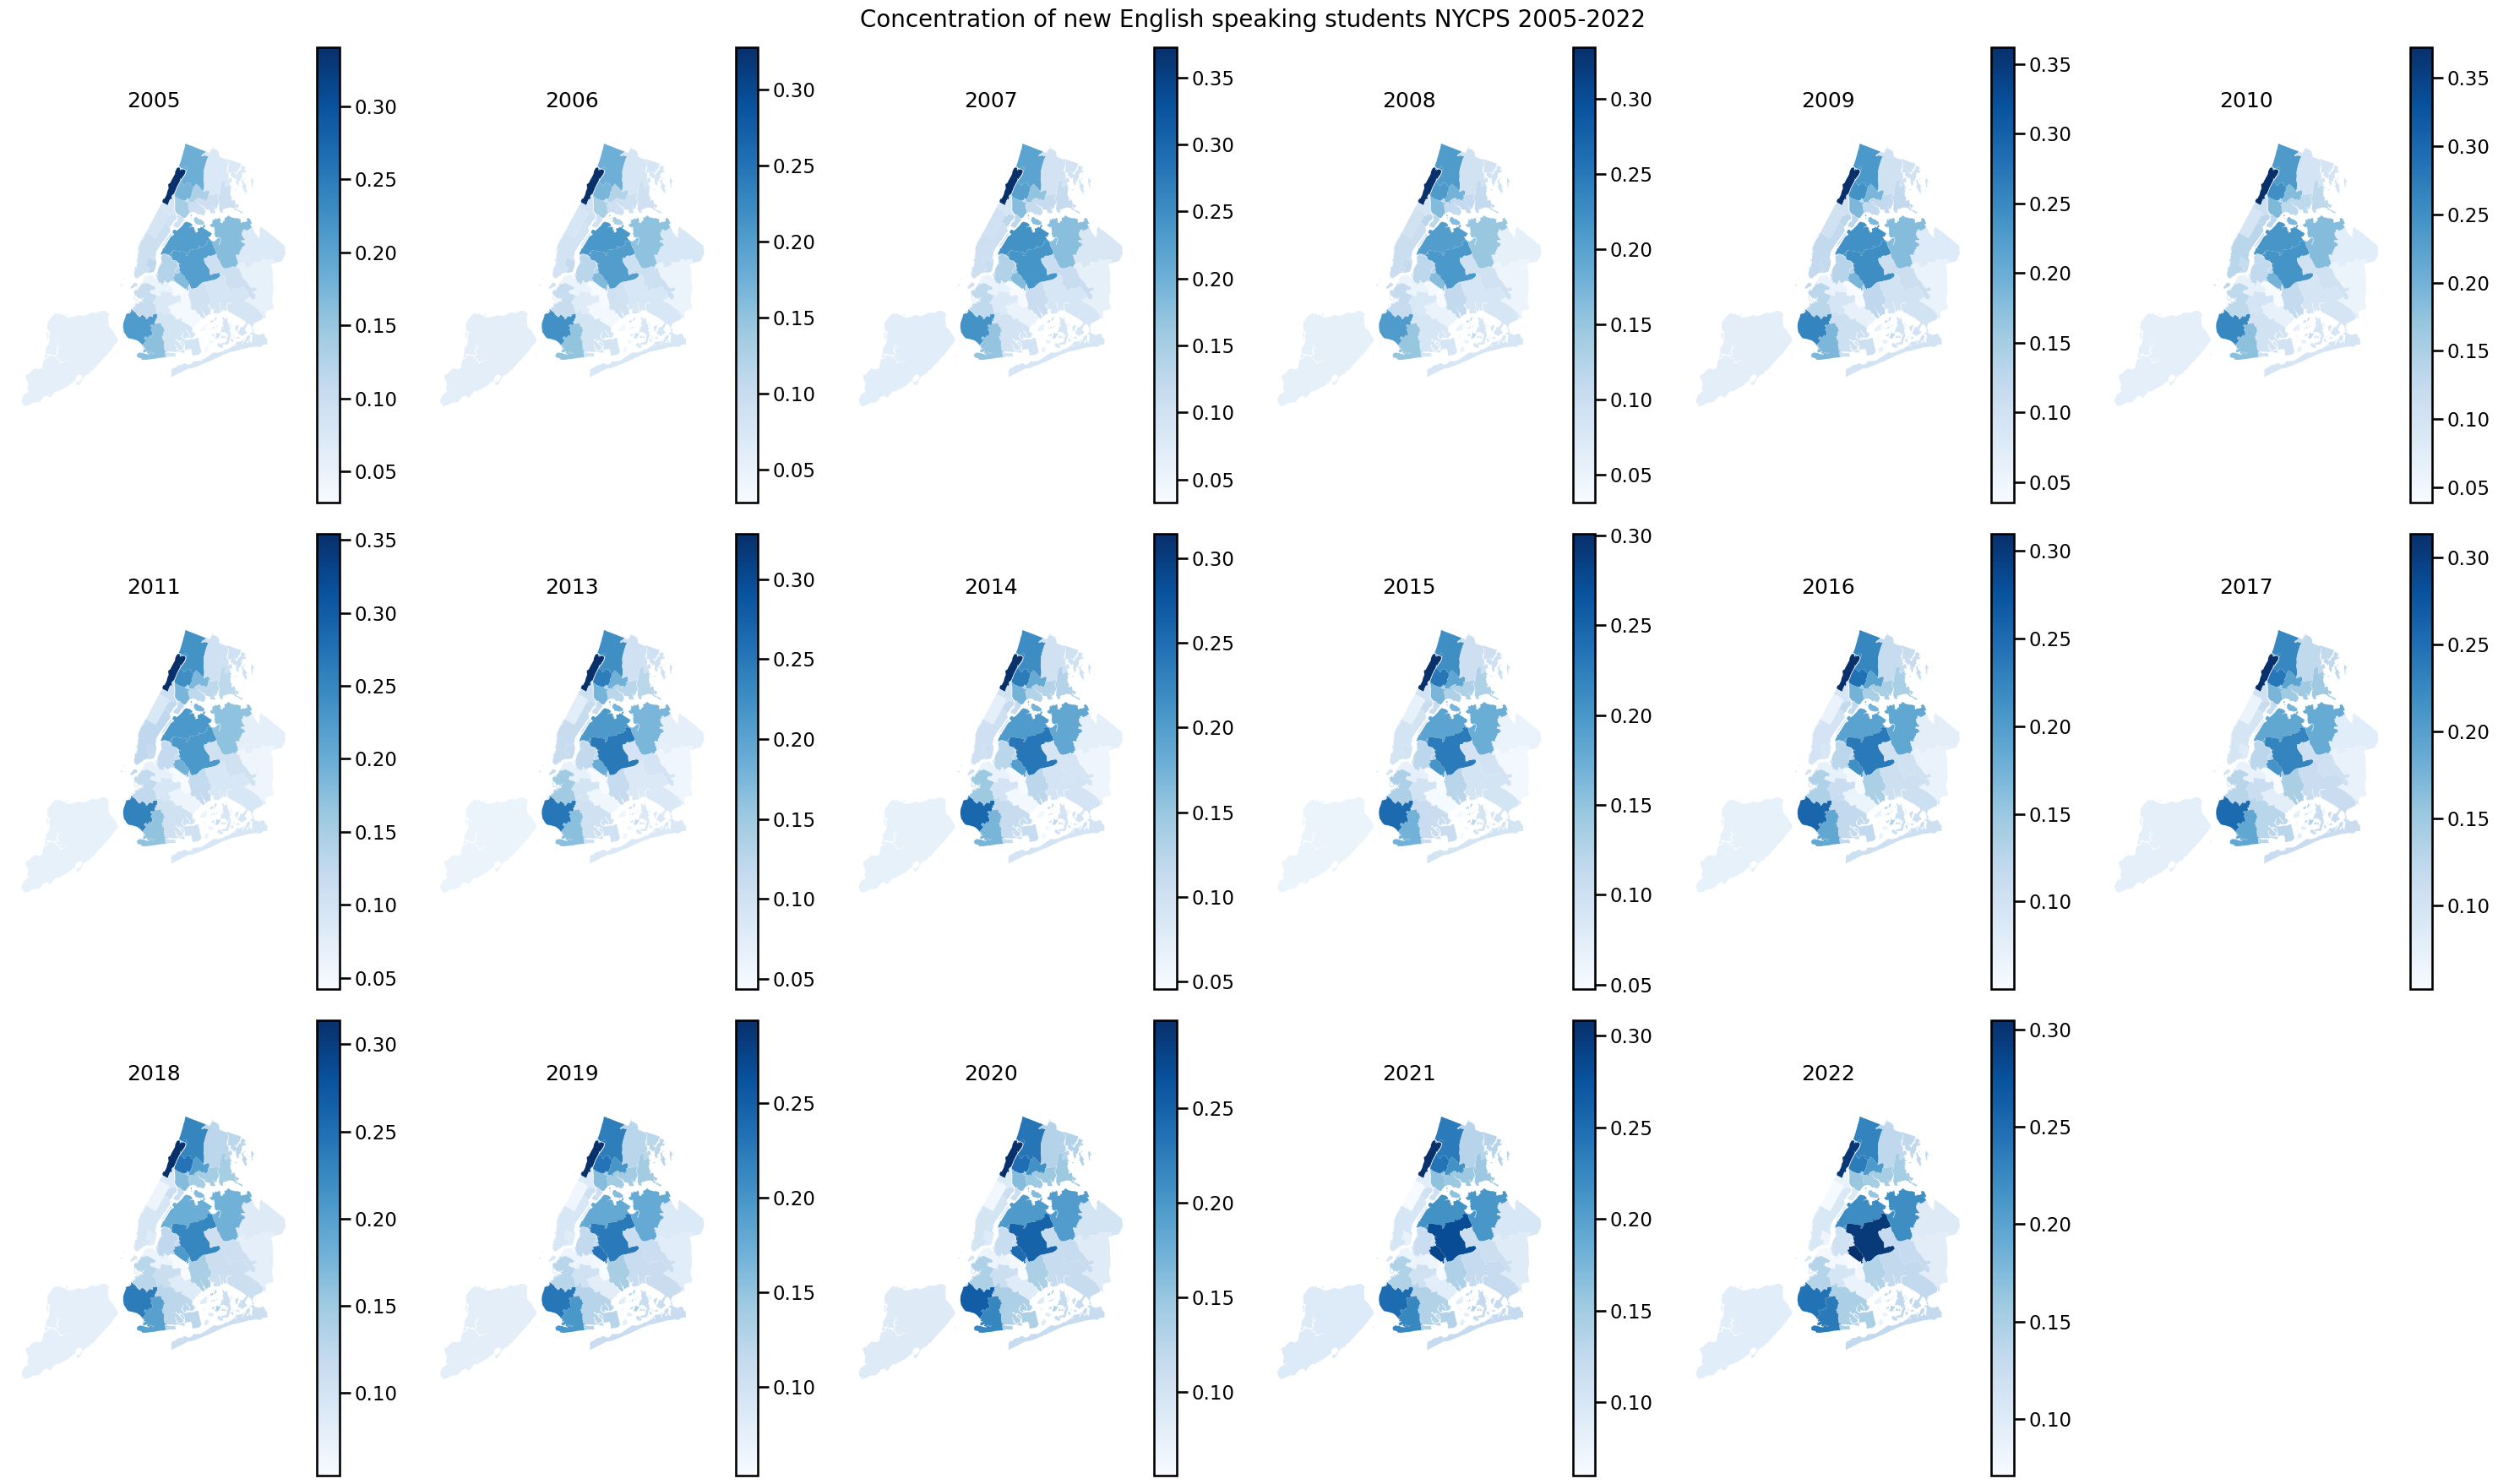

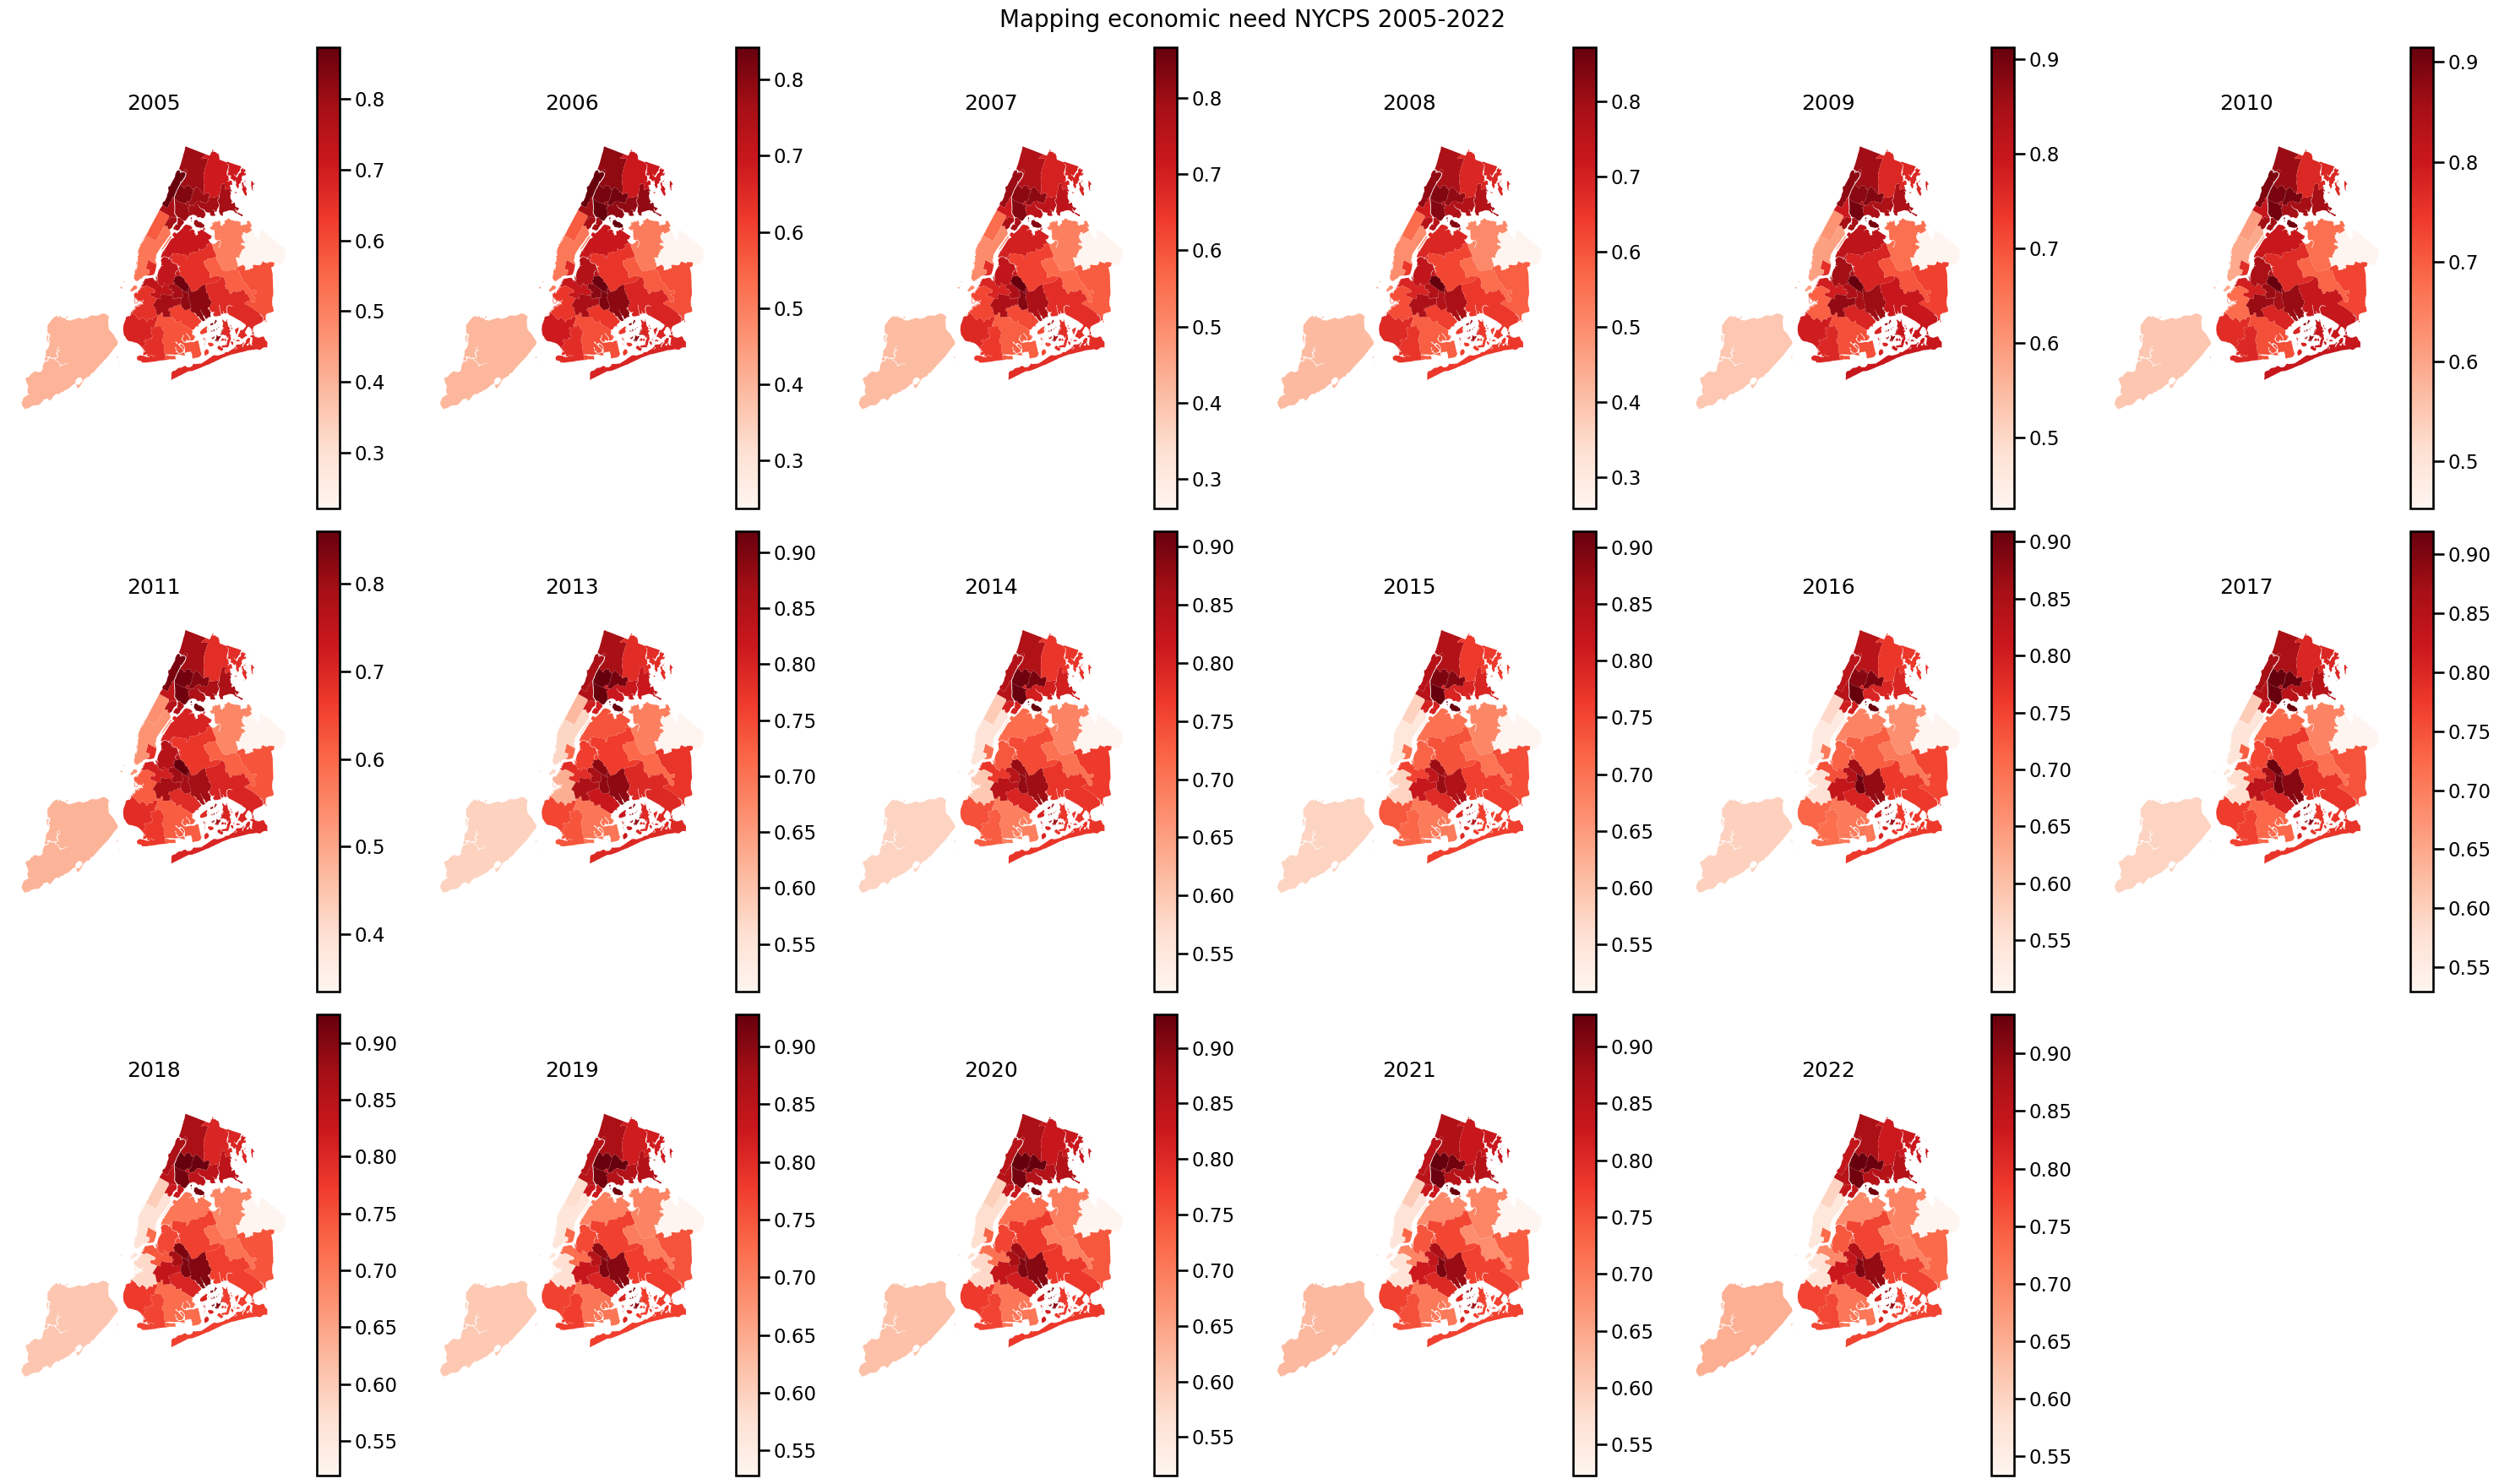

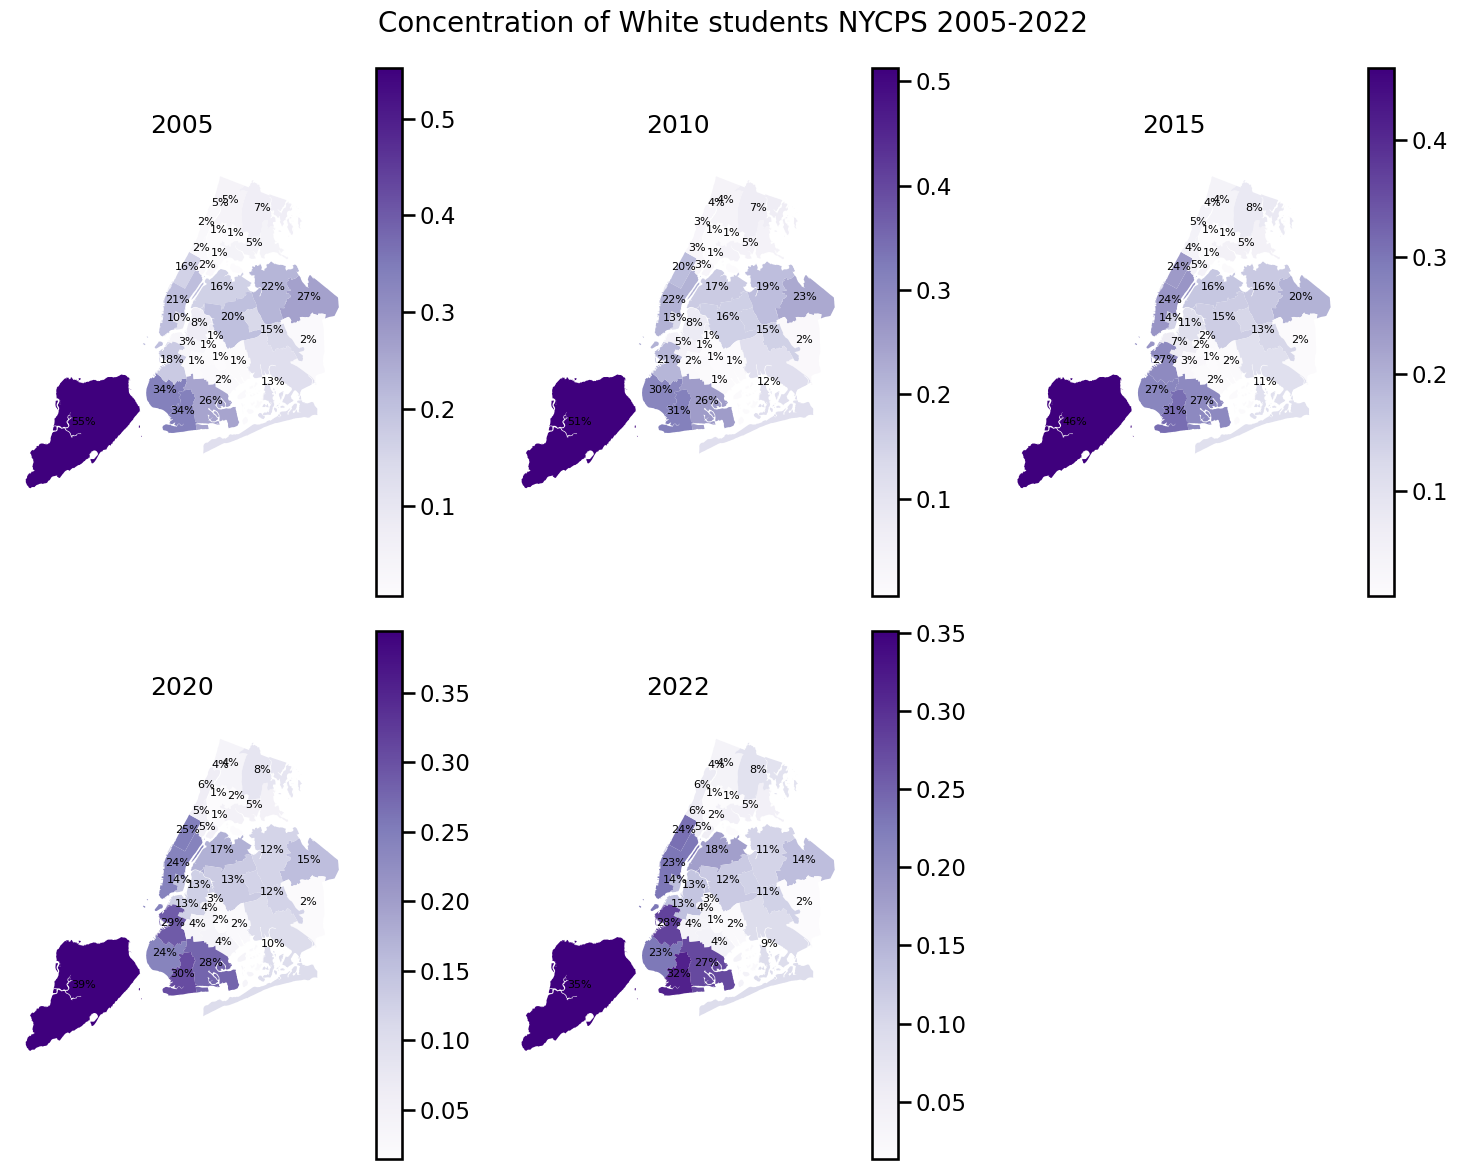

In [7]:
def plot_change(key_col, gdf, title, cmap, labels=False, cols=6):

    vmin = gdf[key_col].min()
    vmax = gdf[key_col].max()

    def plot_choro(ax, data, key_col, title, cmap="Blues", legend=False):
        sns.set_context('talk')

        ax.set_title(title, pad=20)
        ax.axis('off')
        # _ = data.plot(ax=ax, column=key_col, cmap=cmap, legend=legend, vmin=vmin, vmax=vmax)
        _ = data.plot(ax=ax, column=key_col, cmap=cmap, legend=True)

    years = sorted(gdf.ay.unique())
    # create a grid with 4 columns and as many rows as we need
    cols = min(cols, len(years))
    rows = math.ceil(len(years) / cols)
    # each cell will be 5in x 6in
    fig, axs = plt.subplots(rows, cols, figsize=(5*cols, 6*rows))
    axs = axs.flatten()


    for y, ax in zip(years, axs[:len(years)]):
        map_data = gdf[gdf.ay == y].groupby("district").agg({key_col: "mean"}).reset_index()
        # merge it back with our geodata
        map_data = districts.merge(map_data, on="district", how="inner")

        plot_choro(ax, map_data, key_col, str(y), cmap, legend=(y == years[-1]))
        if labels:
            map_data["label"] = map_data[key_col].apply(lambda x: f"{x:.0%}")
            ui.label_plot(ax, map_data, "label")


    for ax in axs[len(years):]:
        ax.axis('off')

    fig.suptitle(f'{title} {years[0]}-{years[-1]}', fontsize=20)
    fig.tight_layout()
    plt.show()


district_demo = districts.merge(demos, on="district", how="inner")

plot_change("ell_pct", demos, "Concentration of new English speaking students NYCPS", cmap="Blues")
plot_change("poverty_pct", demos, "Mapping economic need NYCPS", cmap="Reds")
plot_change("white_pct", demos[demos.ay.isin([2005, 2010, 2015, 2020, 2022])], "Concentration of White students NYCPS", cols=3, cmap="Purples", labels=True)